## PHY 411: Final Project
### Jeremy Kazimer
### jdkazime@buffalo.edu

#### _Import Statements_

As always, the import statements:

In [1]:
import sys
sys.path.insert(1, 'utility/')

from generate_network import *
from calculate_entropy import *

And a few other libraries we'll need later:

In [24]:
from numpy import arange, zeros
from matplotlib import pyplot as plt

#### _Building the Partition_

Suppose that we have a partitioned system with two separate communities.  Each community has the same number of nodes, $N = 50$, and they all have equal potential to interact with one another, $p_{in} = 1$.  For the time being, we keep them separated so that the partitions cannot interact, $p_{out} = 0$.  We can form the network:

In [3]:
N = 100
p_in = 1
p_out = 0
k = 2

In [4]:
G = SBM(N, p_in, p_out, k = k)

Of course, some plots to verify:

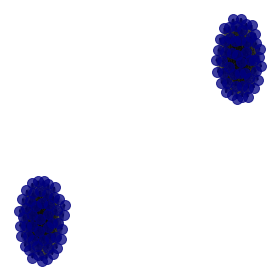

In [5]:
fig, ax = G.plot_networkx()

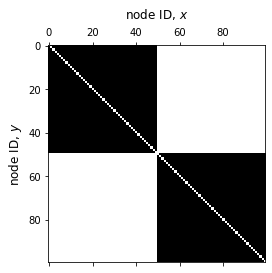

In [6]:
fig, ax = G.plot_graph()

#### _Finding the Most Important Edges_

Now that we have the graph object, we can use it to find the most important edges for energy transfer.  We'll assume $\beta = 1$ to prevent any interference.  We will also use 10% as our cutoff.  This number is really arbitrary as long as it isn't too large, say greater than 25%.

In [7]:
edge_colors, locs = G.get_edge_colors('grey', 'red')

In [10]:
Hs, sorts, ranks = edge_rankings(G)

In [11]:
cutoff = 0.10
perc = top_ranked(sorts, locs, cutoff = cutoff)

In [12]:
print('number of connecting edges in top 10%: {}%'.format(perc))

number of connecting edges in top 10%: 0.0%


Of course, which makes sense.  The particles aren't interacting, so it doesn't make sense for there to be any connecting edges.  Now, to change this up, we can introduce rewiring.

In [43]:
num_rewires = 5000
update_idx = 250
cutoff = 0.10

percs = zeros((num_rewires//update_idx + 1))
G1 = G.copy_graph()
for t in range(num_rewires + 1):
    G1.rewire_graph()
    if t % update_idx == 0 and t != 0:
        _, locs = G1.get_edge_colors('_', '-')
        _, sorts, _ = edge_rankings(G1)
        perc = top_ranked(sorts, locs, cutoff = cutoff)
        percs[t//update_idx] = perc
        
        print('{:.2f}% done!'.format(((t)/num_rewires)*100), '\r', end = '')

And a plot:

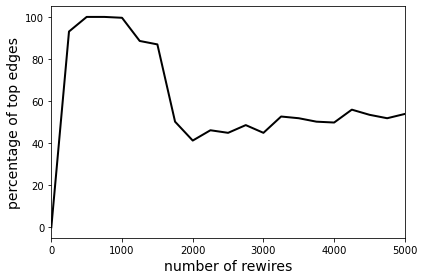

In [45]:
fig, ax = plt.subplots(1, 1)

ax.plot(arange(num_rewires//update_idx + 1)*update_idx, percs, lw = 2, c = 'k')

ax.set_xlim(0, num_rewires)

ax.set_ylabel('percentage of top edges', fontsize = 14)
ax.set_xlabel('number of rewires', fontsize = 14)

fig.tight_layout()

This is exactly what we expect, honestly.  It's apparent that the function grows quickly, but then starts to reach equilibrium as it becomes a random graph with enough rewires.  We can see what the graph looks like after all these rewires:

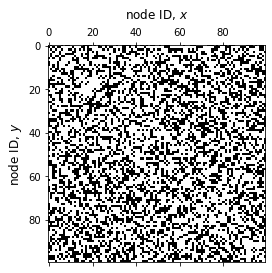

In [46]:
fig, ax = G1.plot_graph()

So, when all edges are equally distributed it makes sense that this is the case.  The system is essentially reaching its equilibrium state.  

But we can do better...right? What I mean is that this is just the case for one graph.  What if we made a bunch of different random graphs and saw how this trend behaved? This is where our Monte Carlo simulation comes into play!

In [48]:
num_rewires = 5000
update_idx = 250
cutoff = 0.10

trials = 10

percs = zeros((trials, num_rewires//update_idx + 1))

for trial in range(trials):
    G1 = SBM(N, p_in, p_out, k = k)
    for t in range(num_rewires + 1):
        G1.rewire_graph()
        if t % update_idx == 0 and t != 0:
            _, locs = G1.get_edge_colors('_', '-')
            _, sorts, _ = edge_rankings(G1)
            perc = top_ranked(sorts, locs, cutoff = cutoff)
            percs[trial, t//update_idx] = perc

    print('{:.2f}% done!'.format(((trial + 1)/trials)*100), '\r', end = '')

The moment of truth...

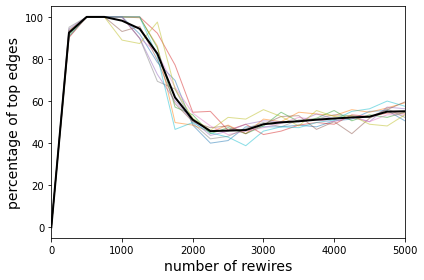

In [57]:
fig, ax = plt.subplots(1, 1)

ts = arange(num_rewires//update_idx + 1)*update_idx

ax.plot(ts, percs.T, alpha = 0.5, lw = 1);
ax.plot(ts, percs.mean(axis = 0), lw = 2, c = 'k')

ax.set_xlim(0, num_rewires)

ax.set_ylabel('percentage of top edges', fontsize = 14)
ax.set_xlabel('number of rewires', fontsize = 14)

fig.tight_layout();

And this behavior really isn't unique to the original curve.  It's almost like a potential energy function; it's quick to excite, but quickly approaches its equilibrium state.  This much we anticipate, again, because after 2000 rewires it appears that the system is more like a random graph than anything else.  We can observe this:

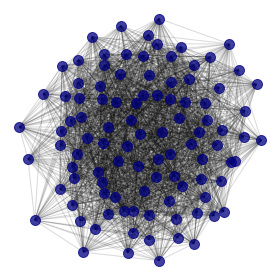

In [58]:
fig, ax = G1.plot_networkx()

Basically, in a short time span it is clear that the most important edges are those of the connecting edges.  But once it reaches a saturation point, this is no longer the case.  Effectively, once energy diffusion no longer requires these particles traveling between communities they lose their usefulness.  This turning point is when the system starts to become indistinguishable.